# TASK I (Text-Only)

## Import important libraries

In [32]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Conv1D, MaxPooling1D
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Dropout, concatenate, LSTM, Conv2D, MaxPooling2D, Flatten, GlobalMaxPooling1D,  Embedding
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import tensorflow as tf
tf.get_logger().setLevel('INFO')

##### Defining some important metrics

In [3]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Load the training, testing and valdiation JSONLs

In [4]:
train_li = []
# Open the JSONL file
with open('./train.jsonl', 'r') as f:
    # Read each line of the file as a separate JSON object
    for line in f:
        train_li.append(json.loads(line))
        
test_li = []
# Open the JSONL file
with open('./test_seen.jsonl', 'r') as f:
    # Read eactest_seen.jsonlh line of the file as a separate JSON object
    for line in f:
        test_li.append(json.loads(line))
        
dev_li = []
# Open the JSONL file
with open('./dev_seen.jsonl', 'r') as f:
    # Read eactest_seen.jsonlh line of the file as a separate JSON object
    for line in f:
        dev_li.append(json.loads(line))
        
## Getting dataframes
train_df = pd.DataFrame(train_li)
test_df = pd.DataFrame(test_li)
dev_df = pd.DataFrame(dev_li)

In [5]:
train_text = train_df['text'].tolist()
test_text = test_df['text'].tolist()
dev_text = dev_df['text'].tolist()

In [6]:
y_train = train_df['label'].tolist()
y_test = test_df['label'].tolist()
y_dev = dev_df['label'].tolist()

### Preprocessing the text

In [7]:
# Preprocess the text data

max_words = 12000
max_len = 256
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(train_df['text'])

sequences_train = tokenizer.texts_to_sequences(train_df['text'])
sequences_val = tokenizer.texts_to_sequences(dev_df['text'])
sequences_test = tokenizer.texts_to_sequences(test_df['text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9135 unique tokens.


### Getting final train, test, val

In [8]:
x_train = pad_sequences(sequences_train, maxlen=max_len)
x_val = pad_sequences(sequences_val, maxlen=max_len)
x_test = pad_sequences(sequences_test, maxlen=max_len)

y_train = to_categorical(train_df['label'])
y_val = to_categorical(dev_df['label'])
y_test = to_categorical(test_df['label'])

# Preprocess the labels
y_train = np.array(train_df['label'])
y_val = np.array(dev_df['label'])
y_test = np.array(test_df['label'])

In [9]:
def return_lstm_model_1():
    text_input = Input(shape=(max_len,))

    text_embedding = Embedding(max_words, 128)(text_input)

    text_lstm = LSTM(64)(text_embedding)

    dense1 = Dense(64, activation='relu')(text_lstm)
    dropout1 = Dropout(0.2)(dense1)

    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)

    dense3 = Dense(8, activation='relu')(dropout2)
    dropout3 = Dropout(0.2)(dense3)

    output = Dense(1, activation='sigmoid')(dropout3)

    model = Model(inputs = text_input, outputs = output)
    
    model.summary()

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy', 'Precision', 'Recall', f1_m])
    
    return model

In [11]:
from keras import regularizers

def return_lstm_model_2():
    text_input = Input(shape=(max_len,))

    text_embedding = Embedding(max_words, 128)(text_input)

    text_lstm_1 = LSTM(128, return_sequences=True)(text_embedding)
    text_lstm_2 = LSTM(64)(text_lstm_1)

    dense1 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(text_lstm_2)
    dropout1 = Dropout(0.5)(dense1)

    dense2 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dropout1)
    dropout2 = Dropout(0.5)(dense2)

    dense3 = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dropout2)
    dropout3 = Dropout(0.5)(dense3)

    output = Dense(1, activation='sigmoid')(dropout3)

    model = Model(inputs=text_input, outputs=output)
    model.summary()

    model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy', 'Precision', 'Recall', f1_m])
    
    return model

In [12]:
def return_lstm_model_3():
    text_input = Input(shape=(max_len,))

    text_embedding = Embedding(max_words, 128)(text_input)

    conv1 = Conv1D(64, 3, activation='relu')(text_embedding)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    text_lstm = LSTM(64)(pool1)

    dense1 = Dense(64, activation='relu')(text_lstm)
    dropout1 = Dropout(0.2)(dense1)

    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)

    dense3 = Dense(8, activation='relu')(dropout2)
    dropout3 = Dropout(0.2)(dense3)

    output = Dense(1, activation='sigmoid')(dropout3)

    model = Model(inputs=text_input, outputs=output)
    model.summary()

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy', 'Precision', 'Recall', f1_m])

    return model


In [13]:
def return_lstm_model_4():
    text_input = Input(shape=(max_len,))

    # Load pre-trained word embeddings
    embeddings_index = {}
    with open('./glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    # Create embedding matrix
    embedding_dim = 100
    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    # Create embedding layer
    text_embedding = Embedding(max_words, embedding_dim, weights=[embedding_matrix], trainable=False)(text_input)

    text_lstm = LSTM(64)(text_embedding)

    dense1 = Dense(64, activation='relu')(text_lstm)
    dropout1 = Dropout(0.2)(dense1)

    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)

    dense3 = Dense(8, activation='relu')(dropout2)
    dropout3 = Dropout(0.2)(dense3)
    
    output = Dense(1, activation='sigmoid')(dropout3)

    model = Model(inputs=text_input, outputs=output)
    model.summary()

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy', 'Precision', 'Recall', f1_m])

    return model

### Evaluation

In [14]:
def plot_history(history = history_lsm):
    
    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [15]:
def get_metrics(model = lstm_model_1):
    
    test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(x_test, y_test)
    train_loss, train_acc, train_precision, train_recall, train_f1 = model.evaluate(x_train, y_train)
    dev_loss, dev_acc, dev_precision, dev_recall, dev_f1 = model.evaluate(x_val, y_val)
    
    
    print("#######################################################################################################")
    print("#######################################################################################################")
    
    print("Following are the TEST metrics associated with the model\n")    
    print(f'Test loss: {test_loss}\n')
    print(f'Test acuuracy: {test_acc}\n')
    print(f'Test precision: {test_precision}\n')
    print(f'Test recall: {test_recall}\n')
    print(f'Test F1-Score: {test_f1}\n')
    y_pred = model.predict(x_test)
    print(classification_report(y_test.reshape(-1,1), y_pred.round()))
    
    print("#######################################################################################################")
    print("#######################################################################################################")
    print("Following are the TRAIN metrics associated with the model\n")    
    print(f'Train loss: {train_loss}\n')
    print(f'Train acuuracy: {train_acc}\n')
    print(f'Train precision: {train_precision}\n')
    print(f'Train recall: {train_recall}\n')
    print(f'Train F1-Score: {train_f1}\n')
    y_pred_train = model.predict(x_train)
    print(classification_report(y_train.reshape(-1,1), y_pred_train.round()))
    
    print("#######################################################################################################")
    print("#######################################################################################################")
    print("Following are the DEV metrics associated with the model\n")    
    print(f'Train loss: {dev_loss}\n')
    print(f'Train acuuracy: {dev_acc}\n')
    print(f'Train precision: {dev_precision}\n')
    print(f'Train recall: {dev_recall}\n')
    print(f'Train F1-Score: {dev_f1}\n')
    y_pred_dev = model.predict(x_val)
    print(classification_report(y_val.reshape(-1,1), y_pred_dev.round()))

### Model - 1

In [40]:
lstm_model_1 = return_lstm_model_1()
history_lstm_1 = lstm_model_1.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 256)]             0         
                                                                 
 embedding_11 (Embedding)    (None, 256, 128)          1536000   
                                                                 
 lstm_12 (LSTM)              (None, 64)                49408     
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dropout_28 (Dropout)        (None, 32)                0   

2023-04-21 12:51:24.261527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 12:51:24.262750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 12:51:24.263539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

264/266 [============================>.] - ETA: 0s - loss: 0.6262 - accuracy: 0.6702 - precision: 0.6441 - recall: 0.1615 - f1_m: 0.2015

2023-04-21 12:51:28.217857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 12:51:28.218950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 12:51:28.219788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

266/266 [==============================] - 4s 11ms/step - loss: 0.6256 - accuracy: 0.6708 - precision: 0.6433 - recall: 0.1643 - f1_m: 0.2048 - val_loss: 0.7374 - val_accuracy: 0.5600 - val_precision: 0.6552 - val_recall: 0.2308 - val_f1_m: 0.3283
Epoch 2/50
266/266 [==============================] - 2s 8ms/step - loss: 0.4888 - accuracy: 0.7758 - precision: 0.7106 - recall: 0.6221 - f1_m: 0.6509 - val_loss: 0.8092 - val_accuracy: 0.5700 - val_precision: 0.6429 - val_recall: 0.2915 - val_f1_m: 0.3773
Epoch 3/50
266/266 [==============================] - 2s 8ms/step - loss: 0.3901 - accuracy: 0.8176 - precision: 0.7688 - recall: 0.6959 - f1_m: 0.7164 - val_loss: 1.0855 - val_accuracy: 0.5380 - val_precision: 0.5976 - val_recall: 0.1984 - val_f1_m: 0.2987
Epoch 4/50
266/266 [==============================] - 3s 13ms/step - loss: 0.3259 - accuracy: 0.8394 - precision: 0.8093 - recall: 0.7168 - f1_m: 0.7508 - val_loss: 1.3470 - val_accuracy: 0.5400 - val_precision: 0.5810 - val_recall: 0.2

In [41]:
get_metrics(lstm_model_1)

16/16 [==============================] - 0s 6ms/step - loss: 6.8218 - accuracy: 0.5220 - precision: 0.5244 - recall: 0.3482 - f1_m: 0.4209
#######################################################################################################
#######################################################################################################
Following are the TEST metrics associated with the model

Test loss: 6.397130012512207

Test acuuracy: 0.5419999957084656

Test precision: 0.5533333420753479

Test recall: 0.33877551555633545

Test F1-Score: 0.41793137788772583

27/32 [========================>.....] - ETA: 0s

2023-04-21 12:54:05.464037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 12:54:05.465253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 12:54:05.466063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.54      0.74      0.62       510
           1       0.55      0.34      0.42       490

    accuracy                           0.54      1000
   macro avg       0.55      0.54      0.52      1000
weighted avg       0.55      0.54      0.52      1000

#######################################################################################################
#######################################################################################################
Following are the TRAIN metrics associated with the model

Train loss: 0.14656448364257812

Train acuuracy: 0.9044705629348755

Train precision: 0.8242726922035217

Train recall: 0.9291155934333801

Train F1-Score: 0.8632691502571106

266/266 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      5481
           1 

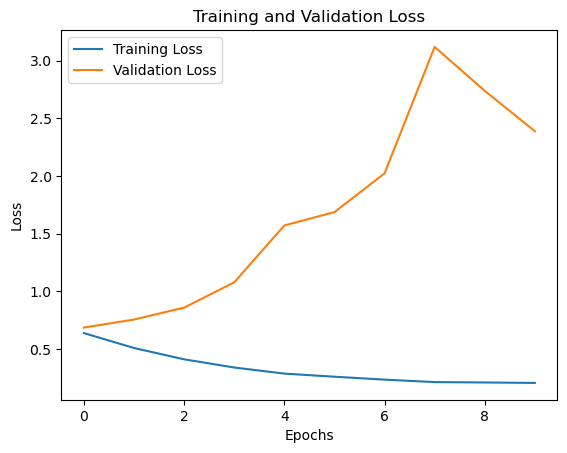

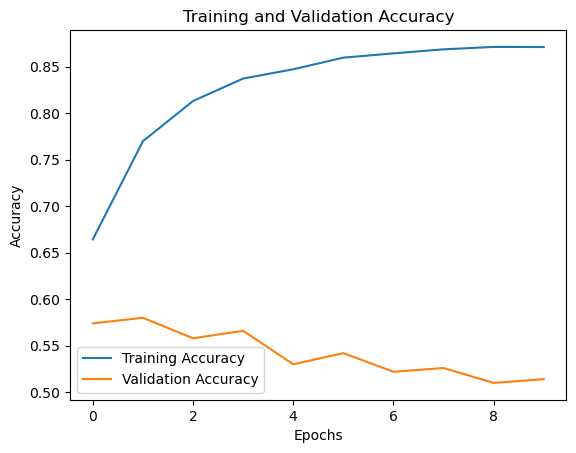

In [42]:
plot_history(history_lsm)

### Model-2

In [43]:
lstm_model_2 = return_lstm_model_2()
history_lstm_2 = lstm_model_2.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256)]             0         
                                                                 
 embedding_12 (Embedding)    (None, 256, 128)          1536000   
                                                                 
 lstm_13 (LSTM)              (None, 256, 128)          131584    
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_40 (Dense)            (None, 128)               8320      
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_41 (Dense)            (None, 64)                825

2023-04-21 12:54:07.424387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 12:54:07.425529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 12:54:07.426294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-04-21 12:54:07.757165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 12:54:07.758360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 12:54:07.759209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

266/266 [==============================] - ETA: 0s - loss: 1.0733 - accuracy: 0.6386 - precision: 0.3536 - recall: 0.0212 - f1_m: 0.0236

2023-04-21 12:54:15.829874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 12:54:15.831037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 12:54:15.831817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

266/266 [==============================] - 9s 25ms/step - loss: 1.0733 - accuracy: 0.6386 - precision: 0.3536 - recall: 0.0212 - f1_m: 0.0236 - val_loss: 0.7762 - val_accuracy: 0.5060 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/50
266/266 [==============================] - 6s 23ms/step - loss: 0.6601 - accuracy: 0.6448 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.7295 - val_accuracy: 0.5060 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/50
266/266 [==============================] - 6s 23ms/step - loss: 0.5971 - accuracy: 0.6448 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 0.7102 - val_accuracy: 0.5060 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/50
266/266 [==============================] - 6s 22ms/step - loss: 0.5887 - accuracy: 0.6879 - precision: 0.7047 - recall: 0.2087 - f1_m: 0.2289 - val_loss: 0.7605 - 

In [44]:
get_metrics(lstm_model_2)

16/16 [==============================] - 0s 14ms/step - loss: 2.7053 - accuracy: 0.4840 - precision: 0.4762 - recall: 0.4453 - f1_m: 0.4609
#######################################################################################################
#######################################################################################################
Following are the TEST metrics associated with the model

Test loss: 2.3108389377593994

Test acuuracy: 0.49900001287460327

Test precision: 0.48927876353263855

Test recall: 0.5122448801994324

Test F1-Score: 0.49823644757270813



2023-04-21 12:58:40.720409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 12:58:40.721935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 12:58:40.723172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.51      0.49      0.50       510
           1       0.49      0.51      0.50       490

    accuracy                           0.50      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       0.50      0.50      0.50      1000

#######################################################################################################
#######################################################################################################
Following are the TRAIN metrics associated with the model

Train loss: 0.23462632298469543

Train acuuracy: 0.8947058916091919

Train precision: 0.7825971245765686

Train recall: 0.9741636514663696

Train F1-Score: 0.8579731583595276

266/266 [==============================] - 3s 11ms/step
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      5481
           

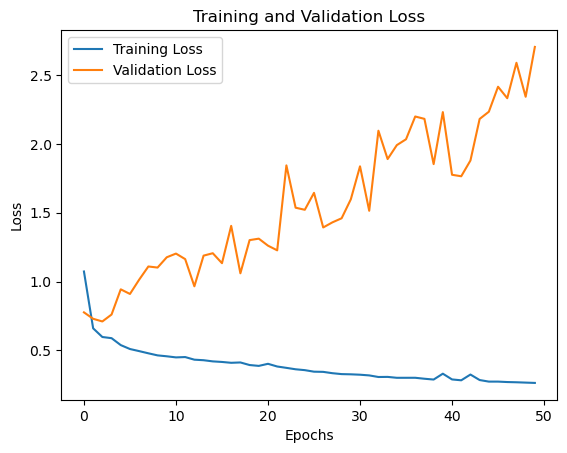

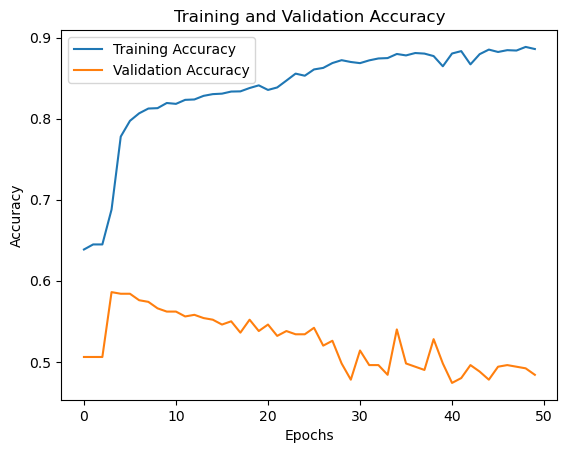

In [45]:
plot_history(history_lstm_2)

### Model - 3

In [46]:
lstm_model_3 = return_lstm_model_3()
history_lstm_3 = lstm_model_3.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 256)]             0         
                                                                 
 embedding_13 (Embedding)    (None, 256, 128)          1536000   
                                                                 
 conv1d_2 (Conv1D)           (None, 254, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 127, 64)          0         
 1D)                                                             
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dense_44 (Dense)            (None, 64)                4160      
                                                          

2023-04-21 12:58:45.703336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 12:58:45.706263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 12:58:45.707145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

262/266 [============================>.] - ETA: 0s - loss: 0.6266 - accuracy: 0.6719 - precision: 0.6324 - recall: 0.1857 - f1_m: 0.2273

2023-04-21 12:58:50.959611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 12:58:50.963095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 12:58:50.964090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

266/266 [==============================] - 6s 13ms/step - loss: 0.6254 - accuracy: 0.6729 - precision: 0.6332 - recall: 0.1881 - f1_m: 0.2309 - val_loss: 0.7437 - val_accuracy: 0.5580 - val_precision: 0.6182 - val_recall: 0.2753 - val_f1_m: 0.3471
Epoch 2/50
266/266 [==============================] - 3s 10ms/step - loss: 0.4968 - accuracy: 0.7653 - precision: 0.7063 - recall: 0.5807 - f1_m: 0.6242 - val_loss: 0.7964 - val_accuracy: 0.5740 - val_precision: 0.6197 - val_recall: 0.3563 - val_f1_m: 0.4361
Epoch 3/50
266/266 [==============================] - 3s 10ms/step - loss: 0.3905 - accuracy: 0.8098 - precision: 0.7527 - recall: 0.6916 - f1_m: 0.7109 - val_loss: 1.0291 - val_accuracy: 0.5420 - val_precision: 0.5763 - val_recall: 0.2753 - val_f1_m: 0.3778
Epoch 4/50
266/266 [==============================] - 3s 11ms/step - loss: 0.3124 - accuracy: 0.8371 - precision: 0.7945 - recall: 0.7300 - f1_m: 0.7491 - val_loss: 1.2476 - val_accuracy: 0.5480 - val_precision: 0.5882 - val_recall: 0

In [47]:
get_metrics(lstm_model_3)

16/16 [==============================] - 0s 3ms/step - loss: 3.9631 - accuracy: 0.5080 - precision: 0.5027 - recall: 0.3765 - f1_m: 0.4320
#######################################################################################################
#######################################################################################################
Following are the TEST metrics associated with the model

Test loss: 3.7579970359802246

Test acuuracy: 0.5360000133514404

Test precision: 0.5329949259757996

Test recall: 0.4285714328289032

Test F1-Score: 0.47045087814331055

 1/32 [..............................] - ETA: 9s

2023-04-21 13:01:11.090075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 13:01:11.091075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 13:01:11.092122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.54      0.64      0.58       510
           1       0.53      0.43      0.48       490

    accuracy                           0.54      1000
   macro avg       0.54      0.53      0.53      1000
weighted avg       0.54      0.54      0.53      1000

#######################################################################################################
#######################################################################################################
Following are the TRAIN metrics associated with the model

Train loss: 0.14254863560199738

Train acuuracy: 0.9035294055938721

Train precision: 0.792497992515564

Train recall: 0.986750602722168

Train F1-Score: 0.8704138994216919

266/266 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      5481
           1   

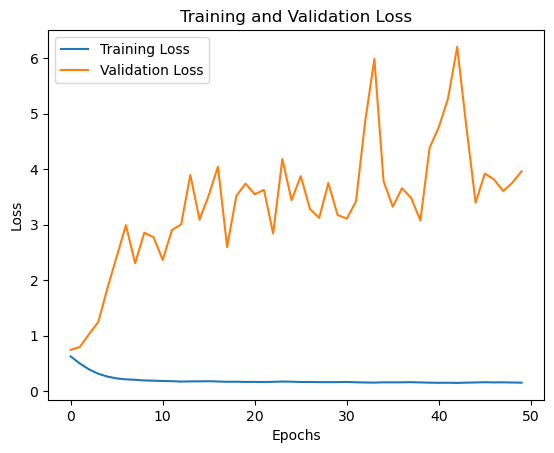

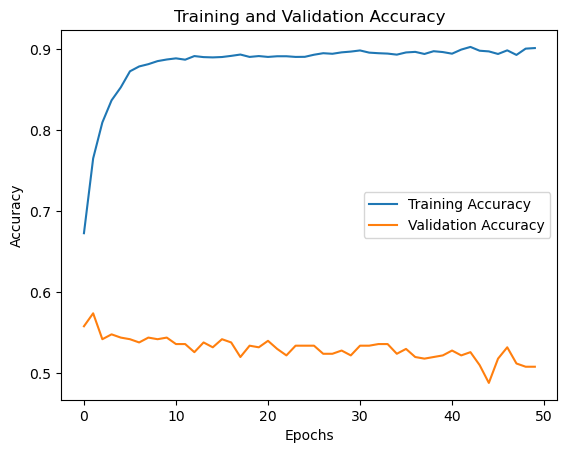

In [48]:
plot_history(history_lstm_3)

### Model 4

In [49]:
lstm_model_4 = return_lstm_model_4()
history_lstm_4 = lstm_model_4.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 256)]             0         
                                                                 
 embedding_14 (Embedding)    (None, 256, 100)          1200000   
                                                                 
 lstm_16 (LSTM)              (None, 64)                42240     
                                                                 
 dense_48 (Dense)            (None, 64)                4160      
                                                                 
 dropout_36 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 32)                2080      
                                                                 
 dropout_37 (Dropout)        (None, 32)                0  

2023-04-21 13:01:23.345362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 13:01:23.351441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 13:01:23.352722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2023-04-21 13:01:23.863274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 13:01:23.865927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 13:01:23.867531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

266/266 [==============================] - ETA: 0s - loss: 0.6313 - accuracy: 0.6519 - precision: 0.5549 - recall: 0.1004 - f1_m: 0.1409

2023-04-21 13:01:29.322143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 13:01:29.323502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 13:01:29.324362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

266/266 [==============================] - 6s 16ms/step - loss: 0.6313 - accuracy: 0.6519 - precision: 0.5549 - recall: 0.1004 - f1_m: 0.1409 - val_loss: 0.7078 - val_accuracy: 0.5560 - val_precision: 0.6016 - val_recall: 0.2996 - val_f1_m: 0.3665
Epoch 2/50
266/266 [==============================] - 4s 14ms/step - loss: 0.5867 - accuracy: 0.7016 - precision: 0.6339 - recall: 0.3786 - f1_m: 0.4506 - val_loss: 0.7905 - val_accuracy: 0.5400 - val_precision: 0.6977 - val_recall: 0.1215 - val_f1_m: 0.1806
Epoch 3/50
266/266 [==============================] - 4s 14ms/step - loss: 0.5669 - accuracy: 0.7196 - precision: 0.6574 - recall: 0.4399 - f1_m: 0.5095 - val_loss: 0.7590 - val_accuracy: 0.5460 - val_precision: 0.6429 - val_recall: 0.1822 - val_f1_m: 0.2573
Epoch 4/50
266/266 [==============================] - 4s 14ms/step - loss: 0.5423 - accuracy: 0.7347 - precision: 0.6819 - recall: 0.4743 - f1_m: 0.5458 - val_loss: 0.7471 - val_accuracy: 0.5460 - val_precision: 0.7083 - val_recall: 0

In [50]:
get_metrics(lstm_model_4)

16/16 [==============================] - 0s 10ms/step - loss: 4.2819 - accuracy: 0.5580 - precision: 0.6048 - recall: 0.3036 - f1_m: 0.3980
#######################################################################################################
#######################################################################################################
Following are the TEST metrics associated with the model

Test loss: 4.041996955871582

Test acuuracy: 0.5720000267028809

Test precision: 0.6156716346740723

Test recall: 0.33673468232154846

Test F1-Score: 0.42475008964538574



2023-04-21 13:04:32.038731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 13:04:32.040798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 13:04:32.044328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.56      0.80      0.66       510
           1       0.62      0.34      0.44       490

    accuracy                           0.57      1000
   macro avg       0.59      0.57      0.55      1000
weighted avg       0.59      0.57      0.55      1000

#######################################################################################################
#######################################################################################################
Following are the TRAIN metrics associated with the model

Train loss: 0.1687285602092743

Train acuuracy: 0.8962352871894836

Train precision: 0.7893311381340027

Train recall: 0.965551495552063

Train F1-Score: 0.8583505749702454

266/266 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      5481
           1   

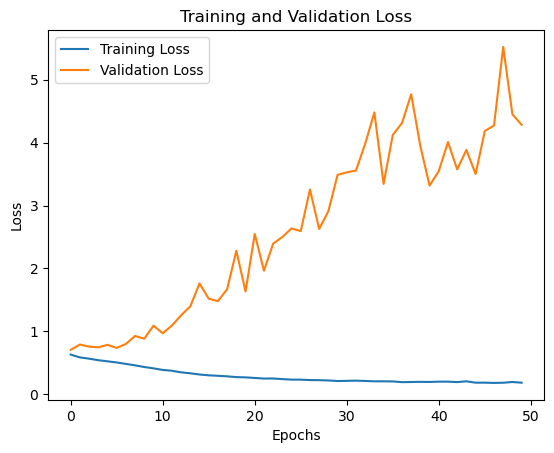

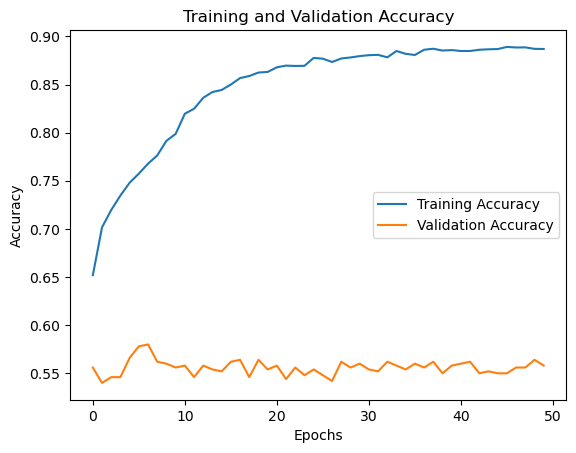

In [51]:
plot_history(history_lstm_4)